<a href="https://colab.research.google.com/github/sobhanshukueian/Can-U-net-learn-pose-estimation/blob/main/Pose_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Can U-Net estimate the positions?

## Done
*  Download and analyze the data.
*  Plot data.
*  Preprocess data.
*  Load data.

---



## TODO



*  Implement the model's architecture.
*  Train model.
*  Evaluate the model.

# Data analyze

Dataset name: MPII Human Pose Dataset

MPII Human Pose dataset is a state of the art benchmark for evaluation of articulated human pose estimation. The dataset includes around 25K images containing over 40K people with annotated body joints.
Link for more information: http://human-pose.mpi-inf.mpg.de/#overview

In [269]:
import re
import os
import cv2
import json
import torch
import torchvision
import requests
import tarfile

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms

from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import scipy.io
from PIL import Image

## Download the dataset


In [ ]:
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz

--2023-08-27 17:52:00--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1.tar.gz
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.206.177
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12088943206 (11G) [application/x-gzip]
Saving to: ‘mpii_human_pose_v1.tar.gz’

mpii_human_pose_v1. 100%[===================>]  11.26G  13.6MB/s    in 11m 55s 

2023-08-27 18:03:56 (16.1 MB/s) - ‘mpii_human_pose_v1.tar.gz’ saved [12088943206/12088943206]



In [ ]:
!wget https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip

--2023-08-27 18:03:57--  https://datasets.d2.mpi-inf.mpg.de/andriluka14cvpr/mpii_human_pose_v1_u12_2.zip
Resolving datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)... 139.19.206.177
Connecting to datasets.d2.mpi-inf.mpg.de (datasets.d2.mpi-inf.mpg.de)|139.19.206.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12340483 (12M) [application/zip]
Saving to: ‘mpii_human_pose_v1_u12_2.zip’

mpii_human_pose_v1_ 100%[===================>]  11.77M  7.80MB/s    in 1.5s    

2023-08-27 18:03:59 (7.80 MB/s) - ‘mpii_human_pose_v1_u12_2.zip’ saved [12340483/12340483]



In [ ]:
fname = '/content/mpii_human_pose_v1.tar.gz'
# Unzip images of dataset
with tarfile.open(fname, 'r') as f:
    f.extractall('.')
    # remove tar file
    os.remove(fname)
    print('Dataset have been unzipped.')

Dataset have been unzipped.


In [ ]:
!unzip "/content/mpii_human_pose_v1_u12_2.zip"

Archive:  /content/mpii_human_pose_v1_u12_2.zip
   creating: mpii_human_pose_v1_u12_2/
  inflating: mpii_human_pose_v1_u12_2/bsd.txt  
  inflating: mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat  
  inflating: mpii_human_pose_v1_u12_2/README.md  


## Plot data

In [ ]:
# Data path
annotations_path = "/content/mpii_human_pose_v1_u12_2/mpii_human_pose_v1_u12_1.mat"
images_folder = "/content/images"

annotations = scipy.io.loadmat(annotations_path, struct_as_record=False, squeeze_me=True)["RELEASE"]

img_train:  1
single_person:  1
act_name :  curling
cat_name  :  sports
act_id  :  1


<ipython-input-256-fd9a1984c8b2>:29: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.resize((200, 200), Image.ANTIALIAS)


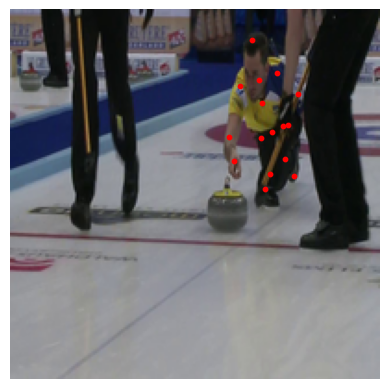

1  Images ha


In [256]:
num=0
for i in range(10):
  example_image_id = i
#   print("img_train: ", annotations.img_train[example_image_id])
#   print("single_person: ", annotations.single_person[example_image_id])



  # Load the selected image information
  image_info = annotations.annolist[example_image_id]

  if hasattr(image_info.annorect, "annopoints"):
    num+=1
    print("img_train: ", annotations.img_train[example_image_id])
    print("single_person: ", annotations.single_person[example_image_id])
    print("act_name : ", annotations.act[example_image_id].act_name)
    print("cat_name  : ", annotations.act[example_image_id].cat_name )
    print("act_id  : ", annotations.act[example_image_id].act_id )
    # print("is_visible  : ", annotations.act[example_image_id].annorect.annopoints.point.'is_visible')



    # Extract image filename
    image_filename = image_info.image.name
    # Load the image using PIL

    image_path = images_folder + "/" + image_filename
    image = Image.open(image_path)
    resized_image = image.resize((200, 200), Image.ANTIALIAS)

    # Display the image
    plt.imshow(resized_image)
    plt.axis("off")

    # Plot annotated joints
    joints= image_info.annorect.annopoints.point
    for joint in joints:
        x, y = joint.x*200/image.size[0], joint.y*200/image.size[1]
        # print(x, y)
        plt.scatter(x, y, color="red", s=10)

            # Plot rectangles around detected individuals
    # person = image_info.annorect
    # if hasattr(person, "x1") and hasattr(person, "y1") and hasattr(person, "x2") and hasattr(person, "y2"):
    #     x1, y1, x2, y2 = person.x1, person.y1, person.x2, person.y2
    #     rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="blue", facecolor="none")
    #     plt.gca().add_patch(rect)
    plt.show()
print(num, " Images ha")

In [264]:
train_data = {
    "images": [],
    "x": [],
    "y": [],
}
val_data = {
    "images": [],
    "x": [],
    "y": [],
}

for i in range(len(annotations.annolist)):
    # Load the selected image information
    image_info = annotations.annolist[i]

    if hasattr(image_info.annorect, "annopoints"):
        if annotations.img_train[i] == 1 and len(train_data["images"]) < 11000:
            train_data["images"].append(image_info.image.name)
            train_data["x"].append(np.array([point.x for point in image_info.annorect.annopoints.point]))
            train_data["y"].append(np.array([point.y for point in image_info.annorect.annopoints.point]))

        else:
            val_data["images"].append(image_info.image.name)
            val_data["x"].append(np.array([point.x for point in image_info.annorect.annopoints.point]))
            val_data["y"].append(np.array([point.y for point in image_info.annorect.annopoints.point]))

print("Train data images number: {}, points number: {}".format(len(train_data["images"]), len(train_data["x"])))
print("Validation data images number: {}, points number: {}".format(len(val_data["images"]), len(val_data["x"])))


Train data images number: 11000, points number: 11000
Validation data images number: 431, points number: 431


## Data Loader

In [359]:
class PoseDataset(torch.utils.data.Dataset):
    def __init__(self, data, image_directory=None, label_sigma=3., transform=None, im_size=(200,200)):
        self.annotations = annotations
        self.image_directory = image_directory
        self.data = data
        self.im_size = im_size

        self.num_landmarks = 17


        # for data augmentation/rescaling
        self.transform = transform

    def __len__(self):
        return len(self.data["images"])

    def __getitem__(self, item):
        filename = os.path.join(self.image_directory, self.data["images"][item])
        assert os.path.exists(filename)
        # print(item, filename)

        im = Image.open(filename)
        im = torch.from_numpy(np.array(im))
        presize = im.shape
        # print(presize)
        resized_image = self.transform(im.permute(2,0,1))
        # plt.imshow(resized_image)
        # plt.show()

        self.num_landmarks=len(self.data['x'][item])

        points = np.column_stack((self.data["x"][item] * self.im_size[0]/presize[1],  self.data["y"][item] * self.im_size[1]/presize[0]))
        heatmaps =  self.make_heatmap_target(points, self.im_size)

        features = {'image':resized_image,
                    'landmarks': points,
                    'heatmaps':heatmaps,
                    'id':item}

        return features

    def make_heatmap_target(self, locs, im_size):
        target = torch.zeros((locs.shape[0], im_size[0], im_size[1]), dtype=torch.float32)
        for i in range(locs.shape[0]):
            # location of this landmark to the nearest pixel
            x = int(np.round(locs[i, 0])) # losing sub-pixel accuracy
            y = int(np.round(locs[i, 1]))
            # edges of the Gaussian filter to place, minding border of image
            x0 = np.maximum(0, x)
            x1 = np.minimum(im_size[1] - 1, x)
            y0 = np.maximum(0, y)
            y1 = np.minimum(im_size[0] - 1, y )

            # print(x0, x1, y0, y1)
            target[i, y0:y1 + 1, x0:x1 + 1] = 1

        return target
    @staticmethod
    def get_image(d, i=None):
        if i is None:
            # im = np.transpose( np.squeeze(d['image'].numpy()), (2,1,0))
            im = torch.squeeze(d['image']).permute(1,2,0).numpy()

        else:
            im = torch.squeeze(d['image'][i]).permute(1,2,0).numpy()
        return im

    @staticmethod
    def get_landmarks(batch, i=None):
        if i is None:
            locs = batch['landmarks']
        else:
            locs = batch['landmarks'][i]
        return locs

    @staticmethod
    def get_heatmap_image(d, i):
        if i is None:
            hm = d['heatmaps']
        else:
            hm = d['heatmaps'][i, ...]
        hm = hm.numpy()
        hm = np.maximum(0., np.minimum(1. ,hm))
        im = np.zeros((hm.shape[1], hm.shape[2], 3))

        cmap = matplotlib.cm.get_cmap('jet')
        colornorm = matplotlib.colors.Normalize(vmin=0, vmax=hm.shape[0])
        colors = cmap(colornorm(np.arange(hm.shape[0])))
        for i in range(hm.shape[0]):
            color = colors[i]
            for c in range(3):
                im[..., c] = im[..., c] + (color[c] *  + .3) * hm[i, ...]

        im = np.minimum(1.,im)
        return im

train_dataset = PoseDataset(train_data, image_directory=images_folder, transform=transforms.Resize((200, 200)))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)

In [360]:
batch_iter = iter(train_dataloader)

In [361]:
batch = next(batch_iter)

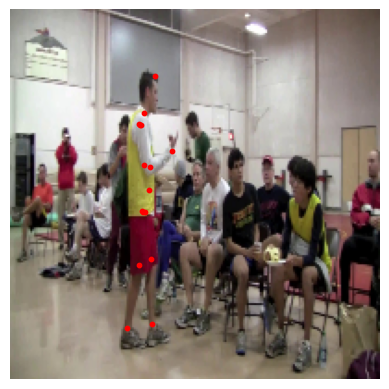

<ipython-input-359-493b4cc0cea9>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


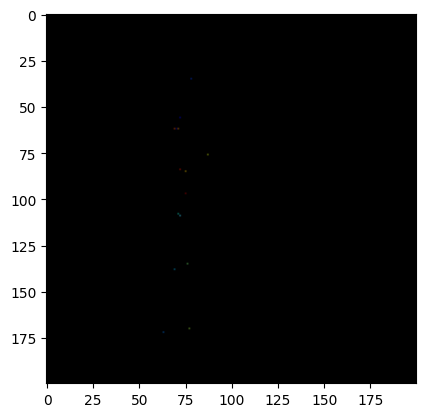

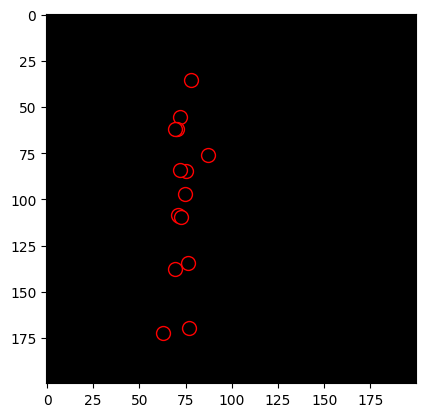

In [362]:
# Display the image
plt.imshow(PoseDataset.get_image(batch))
plt.axis("off")
joints= PoseDataset.get_landmarks(batch)
for joint in joints[0]:
    x, y = joint[0], joint[1]
    # print(x, y)
    plt.scatter(x, y, color="red", s=10)

plt.show()


# batch = next(iter(train_dataloader))
hmim = PoseDataset.get_heatmap_image(batch, 0)
plt.imshow(hmim)
plt.show()

hmim = PoseDataset.get_heatmap_image(batch, 0)
plt.imshow(hmim)

joints= PoseDataset.get_landmarks(batch)
for joint in joints[0]:
    x, y = joint[0], joint[1]
    # print(x, y)
    plt.scatter(x, y, color="black", edgecolors='red', s=100)

plt.show()

<ipython-input-359-493b4cc0cea9>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


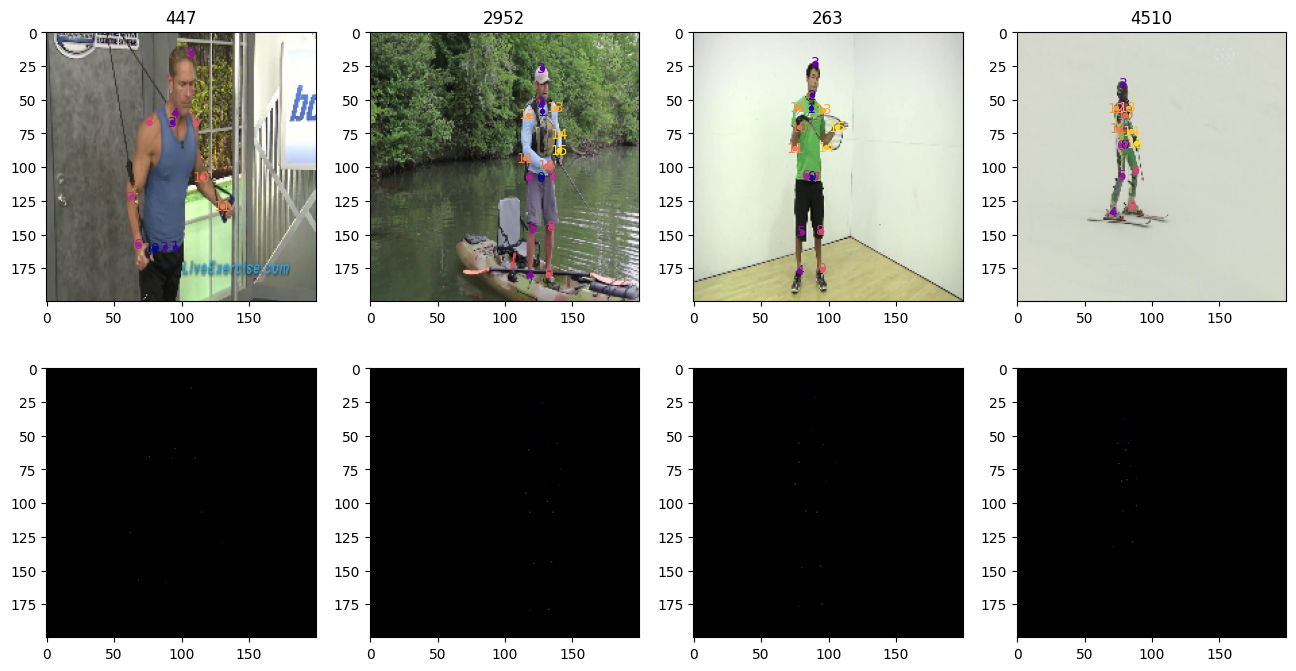

In [363]:
import matplotlib.colors as mcolors

def show_batch(dataloader, dataset, nimsshow=4, cmap='jet', alpha=0.7, background_alpha=0.3):
    fig = plt.figure(figsize=(nimsshow * 4, 8), dpi=100)

    # choose some colors for each landmark
    cmap = plt.get_cmap(cmap)
    colornorm = mcolors.Normalize(vmin=0, vmax=dataset.num_landmarks)
    colors = cmap(colornorm(np.arange(dataset.num_landmarks)))

    count = 0
    for i_batch, sample_batch in enumerate(dataloader):
        for j in range(len(sample_batch['id'])):
            plt.subplot(2, nimsshow, count + 1)
            # use our helper functions for getting and formatting data from the batch
            im = PoseDataset.get_image(sample_batch, j)
            locs = PoseDataset.get_landmarks(sample_batch, j)
            plt.imshow(im, cmap='gray')
            for k in range(dataset.num_landmarks):
                plt.plot(locs[k, 0], locs[k, 1], marker='.', color=colors[k], markerfacecolor=colors[k])
                plt.text(locs[k, 0], locs[k, 1], str(k), color=colors[k], fontsize=10, ha='center', va='center')
            plt.title('%d' % sample_batch['id'][j])
            hmim = PoseDataset.get_heatmap_image(sample_batch, j)

            plt.subplot(2, nimsshow, count + 1 + nimsshow)
            plt.imshow(hmim)
            count += 1
            if count >= nimsshow:
                break
        if count >= nimsshow:
            break

    plt.show()

# Example usage:
show_batch(train_dataloader, train_dataset, nimsshow=4, cmap='plasma', alpha=0.7, background_alpha=0.3)

# Model

In [365]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DoubleConv(nn.Module):
  """(convolution => [BN] => ReLU) * 2"""

  def __init__(self, in_channels, out_channels, mid_channels=None):
    super().__init__()
    if not mid_channels:
        mid_channels = out_channels
    self.double_conv = nn.Sequential(
        nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(mid_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.double_conv(x)

class ConvNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.double_conv(x)
        # print("Double Conv ==== >", x.size())
        return x


class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential( nn.MaxPool2d(2), ConvNet(in_channels, out_channels))

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x


class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvNet(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                    diffY // 2, diffY - diffY // 2])
        # input is CHW
        x2 = torchvision.transforms.CenterCrop([x1.size(2), x1.size(3)])(x2)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class OutConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(OutConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

  def forward(self, x):
    return self.conv(x)


class UNet(nn.Module):
    def __init__(self, num_landmarks):
        super(UNet, self).__init__()

        self.num_landmarks = num_landmarks

        print("landmarks Number: ",self.num_landmarks)

        self.inc = ConvNet(1, 64)
        self.down1 = DownConv(64, 128)
        self.down2 = DownConv(128, 256)
        self.down3 = DownConv(256, 512)
        self.down4 = DownConv(512, 1024)

        self.up1 = UpConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.outc = OutConv(64, self.num_landmarks)


    def output(self, x):
      return torch.sigmoid(self.forward(x))
    def forward(self, x):
        x1 = self.inc(x)
        # print(x1.size())

        x2 = self.down1(x1)
        # print(x2.size())

        x3 = self.down2(x2)
        # print(x3.size())

        x4 = self.down3(x3)
        # print(x4.size())

        x5 = self.down4(x4)
        # print(x5.size())
        # print("Finished Encoder ------------")
        x = self.up1(x5, x4)
        # print(x.size())
        x = self.up2(x, x3)
        # print(x.size())

        x = self.up3(x, x2)
        # print(x.size())

        x = self.up4(x, x1)
        # print(x.size())

        logits = self.outc(x)
        return logits


test_data = torch.rand((16, 1, 200, 200))
net = UNet(train_dataset.num_landmarks)
print(test_data.size())
out = net(test_data)
print(out.size())


landmarks Number:  16
torch.Size([16, 1, 200, 200])
torch.Size([16, 16, 200, 200])


In [367]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = UNet(train_dataset.num_landmarks)
net.to(device='device') # have to be careful about what is done on the CPU vs GPU

# try the network out before training
batch = next(iter(train_dataloader))
with torch.no_grad():
  hms0 = net.output(batch['image'].to(device=device))

print(hms0.size())
matplotlib.pyplot.imshow(hms0[:,0][0].cpu())
plt.show()
matplotlib.pyplot.imshow(hms0[:,0][1].cpu())
plt.show()
matplotlib.pyplot.imshow(hms0[:,0][1].cpu()+hms0[:,0][0].cpu())
plt.show()

landmarks Number:  16


RuntimeError: ignored